In [15]:
readexprs = function(path){

  df = read.csv(path , sep=',')
  rownames(df) = df$X
  df = df[, -1]

  return(df)
}

In [31]:
R1 = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/rnaseq_folfox_r.csv')
S1 = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/rnaseq_folfox_s.csv')

In [17]:
GSE19860_R = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE19860_RESISTANT_FOLFOX.csv')
GSE19860_S = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE19860_SENSITIVE_FOLFOX.csv')

In [18]:
GSE28702_R = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE28702_RESISTANT_FOLFOX.csv')
GSE28702_S = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE28702_SENSITIVE_FOLFOX.csv')

In [19]:
GSE52735_R = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE52735_RESISTANT_FOLFOX.csv')
GSE52735_S = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE52735_SENSITIVE_FOLFOX.csv')

In [20]:
GSE69657_R = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE69657_RESISTANT_FOLFOX.csv')
GSE69657_S = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE69657_SENSITIVE_FOLFOX.csv')

In [21]:
GSE72968_R = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE72968_RESISTANT_FOLFOX.csv')
GSE72968_S = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE72968_SENSITIVE_FOLFOX.csv')

In [22]:
GSE81653_R = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE81653_FOLFOX_RESISTANT.csv')
GSE81653_S = readexprs('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Expression/GSE81653_FOLFOX_SENSITIVE.csv')

In [26]:
arrayR = cbind(GSE19860_R, GSE28702_R, GSE52735_R, GSE69657_R, GSE72968_R)
arrayS = cbind(GSE19860_S, GSE28702_S, GSE52735_S, GSE69657_S, GSE72968_S)

In [32]:
edgeR = function(R, S, name){
    
    library(edgeR)
    
    Res = 'R'
    Sen = 'S'
    
    design = factor(c(rep(Res, ncol(R)), rep(Sen, ncol(S))))
    dataset = cbind(R, S)
                    
    group_data = DGEList(counts=dataset, group=factor(design))                
    normaised_counts = calcNormFactors(group_data)
    common_dispersion_values = estimateCommonDisp(normaised_counts, verbose=F)
    
    gene_exacts_test = exactTest(common_dispersion_values, pair=c(Res,Sen))
    
    Differential_genes = topTags(gene_exacts_test, n=Inf, adjust.method='BH', p.value=0.05)
    Differential_genes = as.data.frame(Differential_genes)
        
    up = subset(Differential_genes, logFC > 1)    
    write.csv(up, paste('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Results/',name, 'DEG.csv', sep=''))
    
    up = R[rownames(up) , ]
    
    return(up)

}

In [33]:
degR1 = edgeR(t(R1),t(S1), 'RNASeq')

Repeated column names found in count matrix



In [59]:
limma = function(df1, df2, name){
    
    library(limma)
    library(data.table)
    library(dplyr)
    
    design = model.matrix(~0 + factor(c(rep(1, ncol(df1)), rep(2, ncol(df2)))))
    colnames(design) = c('R', 'S')
    dataset = cbind(df1, df2)
    
    fit = lmFit(dataset, design, method='ls')
    contrast.matrix = makeContrasts(R-S, levels=design)
    
    fit2 = contrasts.fit(fit, contrast.matrix)
    fit2 = eBayes(fit2, trend=TRUE, robust=TRUE)
    
    results = decideTests(fit2, method='separate', adjust.method='BH', p.value=0.05)
    sig = topTable(fit2, n=Inf, adjust='BH', coef=1, sort.by='P', p.value=0.05)
    
    up = subset(sig, logFC > 0.5)
    write.csv(up, paste('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Results/', name, 'DEG.csv', sep=''))
    
    up = df1[rownames(up) , ]
    
    return(up)

}

In [60]:
deg_GSE81653 = limma(GSE81653_R,GSE81653_S, 'GSE81653')

In [61]:
deg_array = limma(arrayR, arrayS, 'array')

In [72]:
power = function(dataset, name){

  library(WGCNA)

  enableWGCNAThreads(nThreads=32)
  allowWGCNAThreads()
  options(stringsAsFactors = FALSE)

  dataset = t(dataset)

  powers = c(c(1:10), seq(from = 12, to=20, by=2))
  sft = pickSoftThreshold(dataset, powerVector = powers, verbose = 5)

  pdf(file=paste('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Results/Power', name, sep=''))

  par(mfrow = c(1,2))
  plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
       xlab='Soft Threshold (power)', cex.lab=1.2, cex.axis=1.2, cex.main=1.2, cex.sub=1.2,
       ylab='Scale Free Topology Model Fit,signed R^2',type='n',
       main = paste('Scale independence'))

  text(sft$fitIndices[, 1], -sign(sft$fitIndices[, 3])*sft$fitIndices[, 2],
       labels=powers,cex=1, col='red')
  abline(h=0.85,col='red')

  plot(sft$fitIndices[,1], sft$fitIndices[,5], cex.lab=1.2, cex.axis=1.2, cex.main=1.2, cex.sub=1.2,
       xlab='Soft Threshold (power)',ylab='Mean Connectivity', type='n',
       main = paste('Mean connectivity'))

  text(sft$fitIndices[, 1], sft$fitIndices[, 5],
       labels=powers, cex=1, col='red')

  dev.off()

}

In [73]:
GSE81653_power = power(deg_GSE81653,'GSE81653.pdf')

Warning in allowWGCNAThreads: Requested number of threads is higher than number
 of available processors (or cores). Using too many threads may degrade code performance. It is recommended that the number of threads is no more than number
 of available processors.

Allowing parallel execution with up to 32 working processes.
Allowing multi-threading with up to 12 threads.
pickSoftThreshold: will use block size 6.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 6 of 6
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.   max.k.
1      1   0.0021 -0.698         0.0529 1.150000  1.31e+00 1.780000
2      2   0.0609 -1.890         0.0290 0.495000  5.28e-01 0.965000
3      3   0.1300 -3.290         0.2430 0.262000  2.50e-01 0.593000
4      4   0.0515 -1.960         0.3700 0.153000  1.33e-01 0.380000
5      5   0.0393 -1.470         0.1820 0.093900  7.61e-02 0.247000
6      6   0.0636 -1.570         0.1520 0.059200  4.55e-02 0.162000
7   

In [74]:
array_power = power(deg_array,'array.pdf')

Warning in allowWGCNAThreads: Requested number of threads is higher than number
 of available processors (or cores). Using too many threads may degrade code performance. It is recommended that the number of threads is no more than number
 of available processors.

Allowing parallel execution with up to 32 working processes.
Allowing multi-threading with up to 12 threads.
pickSoftThreshold: will use block size 171.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 171 of 171
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0811 -0.162         0.0894  40.400  4.02e+01  64.20
2      2   0.7960 -0.558         0.7630  14.700  1.26e+01  32.00
3      3   0.8710 -0.743         0.8510   6.650  5.58e+00  18.30
4      4   0.8870 -0.828         0.8740   3.490  2.79e+00  11.50
5      5   0.9090 -0.951         0.9640   2.030  1.40e+00   8.21
6      6   0.8040 -1.060         0.8540   1.290  8.58e-01   6.27
7      7   0.2090 -

In [75]:
R_power = power(degR1,'RNASeq.pdf')

Warning in allowWGCNAThreads: Requested number of threads is higher than number
 of available processors (or cores). Using too many threads may degrade code performance. It is recommended that the number of threads is no more than number
 of available processors.

Allowing parallel execution with up to 32 working processes.
Allowing multi-threading with up to 12 threads.
pickSoftThreshold: will use block size 1292.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1292 of 1292


Warning message in eval(xpr, envir = envir):
“Some correlations are NA in block 1 : 1292 .”
Warning message in eval(xpr, envir = envir):
“Some correlations are NA in block 1 : 1292 .”
Warning message in eval(xpr, envir = envir):
“Some correlations are NA in block 1 : 1292 .”
Warning message in eval(xpr, envir = envir):
“Some correlations are NA in block 1 : 1292 .”
Warning message in eval(xpr, envir = envir):
“Some correlations are NA in block 1 : 1292 .”
Warning message in eval(xpr, envir = envir):
“Some correlations are NA in block 1 : 1292 .”
Warning message in eval(xpr, envir = envir):
“Some correlations are NA in block 1 : 1292 .”
Warning message in eval(xpr, envir = envir):
“Some correlations are NA in block 1 : 1292 .”
Warning message in eval(xpr, envir = envir):
“Some correlations are NA in block 1 : 1292 .”
Warning message in eval(xpr, envir = envir):
“Some correlations are NA in block 1 : 1292 .”
Warning message in eval(xpr, envir = envir):
“Some correlations are NA in block 

   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.3260  3.670          0.164   586.0     650.0    825
2      2   0.5850  0.682          0.514   375.0     417.0    632
3      3   0.0264  0.041          0.359   274.0     288.0    522
4      4   0.2720 -0.148          0.761   215.0     211.0    451
5      5   0.5830 -0.269          0.849   176.0     164.0    400
6      6   0.7270 -0.338          0.898   149.0     131.0    361
7      7   0.8150 -0.395          0.922   128.0     107.0    329
8      8   0.8770 -0.435          0.963   113.0      91.1    304
9      9   0.8960 -0.480          0.965   100.0      77.6    282
10    10   0.9150 -0.507          0.972    89.8      67.1    263
11    12   0.9390 -0.557          0.968    74.1      50.6    233
12    14   0.9220 -0.607          0.921    62.7      39.9    211
13    16   0.9440 -0.639          0.945    54.1      31.9    192
14    18   0.9530 -0.667          0.946    47.4      26.2    177
15    20   0.9630 -0.688 

In [97]:
TOM_Matrices = function(dataset, name){

  library(WGCNA)

  enableWGCNAThreads(nThreads=12)
  allowWGCNAThreads()
  options(stringsAsFactors = FALSE)

  dataset = t(dataset)
  adj = abs(cor(dataset, use='p'))^7

  dissTOM = TOMdist(adj)
  hierTOMa = hclust(as.dist(dissTOM), method='average')

  Gene_Modules = labels2colors(cutreeDynamic(hierTOMa, method='tree', cutHeight=0.99))
  Gene_Clusters = labels2colors(cutreeDynamic(hierTOMa, distM= dissTOM , cutHeight = 0.99,
                                               deepSplit=3, pamRespectsDendro = FALSE))


  pdf(file=paste('/home/lebo/Downloads/CRCPhenotypePredictionTool-main/Results/Dendro', name, sep=''))

  plotDendroAndColors(hierTOMa,
                      colors = data.frame(Gene_Clusters),
                      dendroLabels = FALSE,
                      cex.axis = 1.2)

  dev.off()

  return(Gene_Modules)

}

In [ ]:
array = TOM_Matrices(deg_array, 'array')

Allowing parallel execution with up to 12 working processes.
Allowing multi-threading with up to 12 threads.
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..done.


In [99]:
rnaseq = TOM_Matrices(degR1, 'RNASeq')

Allowing parallel execution with up to 12 working processes.
Allowing multi-threading with up to 12 threads.
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..done.


In [ ]:
GSE81653 = TOM_Matrices(deg_GSE81653, 'GSE81653')

Allowing parallel execution with up to 12 working processes.
Allowing multi-threading with up to 12 threads.
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
[1] "No module detected"
 cutHeight set too low: no merges below the cut.


In [101]:
eigenetic_network = function(dataset, colorh1){

  enableWGCNAThreads(nThreads=32)
  allowWGCNAThreads()
  options(stringsAsFactors = FALSE)

  ADJ1 = abs(cor(t(dataset), use='p'))^7

  colors = unique(colorh1)
  Alldegrees1 = intramodularConnectivity(ADJ1, colorh1)

  datME = moduleEigengenes(t(dataset),colorh1)$eigengenes
  MET = orderMEs(cbind(datME))
  datKME = signedKME(t(dataset), datME, outputColumnName='')

  return(datKME)

}

In [102]:
array_eigenes = eigenetic_network(deg_array, array)

Warning in allowWGCNAThreads: Requested number of threads is higher than number
 of available processors (or cores). Using too many threads may degrade code performance. It is recommended that the number of threads is no more than number
 of available processors.

Allowing parallel execution with up to 32 working processes.
Allowing multi-threading with up to 12 threads.


In [ ]:
rnaseq_eigenes = eigenetic_network(degR1, rnaseq)

Warning in allowWGCNAThreads: Requested number of threads is higher than number
 of available processors (or cores). Using too many threads may degrade code performance. It is recommended that the number of threads is no more than number
 of available processors.

Allowing parallel execution with up to 32 working processes.
Allowing multi-threading with up to 12 threads.


Warning message in signedKME(t(dataset), datME, outputColumnName = ""):
“Some genes are constant. Hint: consider removing constant columns from datExpr.”


In [ ]:
GSE81653_eigenes = eigenetic_network(deg_GSE81653, GSE81653)

Warning in allowWGCNAThreads: Requested number of threads is higher than number
 of available processors (or cores). Using too many threads may degrade code performance. It is recommended that the number of threads is no more than number
 of available processors.

Allowing parallel execution with up to 32 working processes.
Allowing multi-threading with up to 12 threads.


In [114]:
cbind.fill = function (...){

  nm = list(...)
  nm = lapply(nm, as.matrix)

  n = max(sapply(nm, nrow))
  do.call(cbind, lapply(nm, function (x)
    rbind(x, matrix(, n-nrow(x), ncol(x)))))

}
                

In [187]:
enrichment = function(dataset, colorh1, datKME){
    
    library(clusterProfiler)
    library(dplyr)
    library(org.Hs.eg.db)
    library(enrichplot)
    
    intModules = table(colorh1)
    intModules = as.data.frame(intModules)
    intModules =intModules$colorh1
    intModules = as.character(intModules)
    
    dat = data.frame()
    dat_new = data.frame()
    
    colrs = c()
    newclors = c()
    
    dataset = t(dataset)
    for (color in intModules){
        
        color =  color
        FilterGenes = abs(subset(datKME, select=c(color))) > 0.8
        genes = dimnames(data.frame(dataset))[[2]][FilterGenes]
        
        dat = cbind.fill(dat, genes, fill = NA)
        colrs = append(color, colrs)
    
    }
    
    dat = dat[,seq(1,ncol(dat),2)]
    colnames(dat) = colrs
    dat = as.data.frame(dat)
    
    dat = dat[,!names(dat) %in% c("grey")]
    colrs = colnames(dat)
    
    for (j in 1:ncol(dat)){
        
        gene = dat[, j]
        
        if (all(is.na(gene)) == FALSE){
            
            eg = bitr(gene, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
            genes <- eg$ENTREZID
            dat_new <- cbind.fill(dat_new, genes, fill = NA)
            newclors <- append(newclors, colrs[j])
            
        }
        
    
    }
    
    dat_new = dat_new[,seq(1, ncol(dat_new), 2)]
    colnames(dat_new) = newclors
    dat_new = as.data.frame(dat_new)
    
    return(dat_new)

}

In [188]:
array_enrich = enrichment(deg_array, array, array_eigenes)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“8.33% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns



In [182]:
GSE81653_enrich = enrichment(deg_GSE81653, GSE81653, GSE81653_eigenes)

ERROR: Error in `colnames<-`(`*tmp*`, value = colrs): attempt to set 'colnames' on an object with less than two dimensions


In [183]:
rnaseq_enrich = enrichment(degR1, rnaseq, rnaseq_eigenes)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“1.17% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“1.82% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“1.5% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“1.88% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“1.41% of input gene IDs are fail to map...”
'

In [184]:
clusterPr = function(dat_new){
    
    dat_new = dat_new[,!names(dat_new) %in% c("grey")]
    
    ck = compareCluster(geneCluster = dat_new, fun = "enrichKEGG", pvalueCutoff = 0.05, pAdjustMethod = "BH")
    
    cKEGG = setReadable(ck, OrgDb = org.Hs.eg.db, keyType="ENTREZID")
    cBp = compareCluster(geneCluster = dat_new, fun = "enrichGO", pvalueCutoff = 0.05, OrgDb = org.Hs.eg.db,
                         ont = "BP", pAdjustMethod = "BH")
    
    cGO = setReadable(cBp, OrgDb = org.Hs.eg.db, keyType="ENTREZID")
    
    dotplot(ck)
    #dotplot(cGO)

}

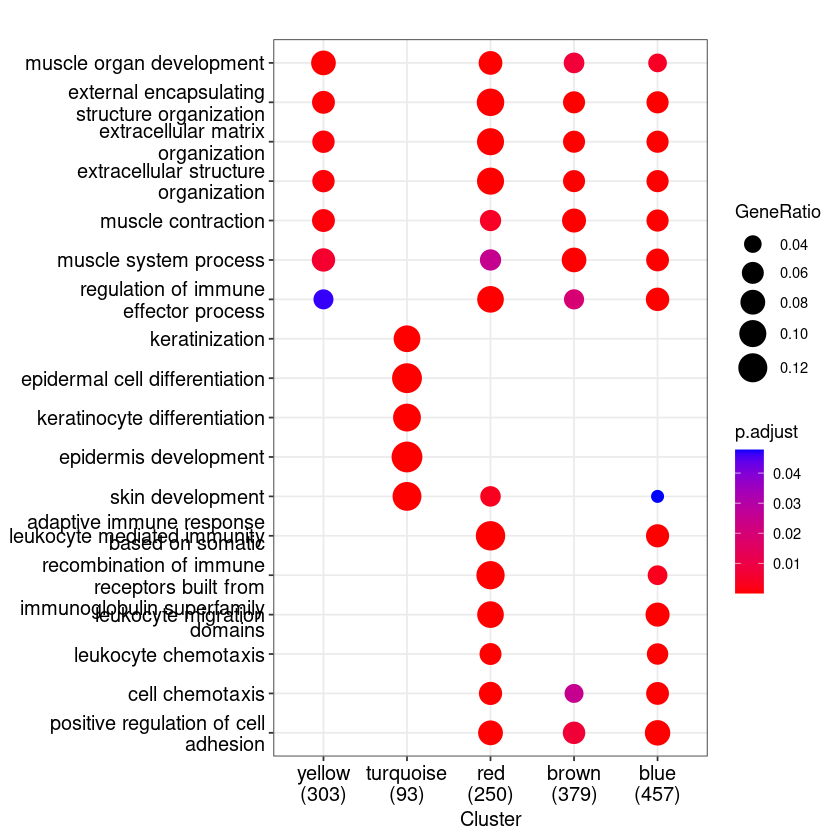

In [185]:
clusterPr(rnaseq_enrich)

In [ ]:
clusterPr(array_enrich)

Warning message in compareCluster(geneCluster = dat_new, fun = "enrichKEGG", pvalueCutoff = 0.05, :
“No enrichment found in any of gene cluster, please check your input...”


ERROR: Error in setReadable(ck, OrgDb = org.Hs.eg.db, keyType = "ENTREZID"): input should be an 'enrichResult' , 'gseaResult' or 'compareClusterResult' object...
